# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.8.0
/device:GPU:0


In [2]:
# datasets for tf
from data_preprocessing_3d import get_dataset_large

batch_size = 4
dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\train"
)
dataset = dataset.batch(batch_size)
valid_dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\valid"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

for sample in valid_dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

print(dataset)
print(valid_dataset)

['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\aa\\images0.tfrecords']
['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\bb\\images1.tfrecords']
(4, 32, 64, 64, 1)
(4, 32, 64, 64, 2)
(4, 32, 64, 64, 1)
(4, 32, 64, 64, 2)
<BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None))>


In [3]:
### learning rate schedule

def scheduler(epoch, lr):
    if epoch < 2:
        lr = 0.001
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [4]:
# Network set-up
from utils import models

model = models.model_call(model_name="3DUNET",pxz=32,px=64,features=32)

In [5]:
# Metrics and training
 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision_all = tf.keras.metrics.Precision(
    thresholds=0.5)
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision_all,precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 32, 64, 64, 1)]         0           []                    
                                                                                                  
 conv3d (Conv3D)                (None, 32, 64, 64, 32)          896         ['input_1[0][0]']     
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64, 32)         128         ['conv3d[0][0]']      
 alization)                                                                                       
                                                                                                  
 conv3d_1 (Conv3D)              (None, 32, 64, 64, 64)          18496       ['batch_normalizat

In [6]:
# Results
# reading checkpoint if needen
#
#################################
import pandas as pd
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    ModelCheckpoint(
        "models\\3DUNET_lesion_32_32_64\\epoch-{epoch:02d}-valloss-{val_loss:.4f}-{val_precision_1:.2f}-{val_recall:.2f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
    ),
    TerminateOnNaN(),
]
epochs = 6

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0
)


hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/6
    125/Unknown - 51s 349ms/step - loss: 0.4252 - precision: 0.8244 - precision_1: 0.1462 - recall: 0.1735
Epoch 1: saving model to models\3DUNET_lesion_32_32_64\epoch-01-valloss-0.0394-0.00-0.06.hdf5
125/125 [==============================] - 68s 489ms/step - loss: 0.4252 - precision: 0.8244 - precision_1: 0.1462 - recall: 0.1735 - val_loss: 0.0394 - val_precision: 0.9741 - val_precision_1: 0.0042 - val_recall: 0.0626 - lr: 0.0010
Epoch 2/6
125/125 [==============================] - ETA: 0s - loss: 0.2431 - precision: 0.7683 - precision_1: 0.1836 - recall: 0.4749
Epoch 2: saving model to models\3DUNET_lesion_32_32_64\epoch-02-valloss-0.0933-0.00-0.35.hdf5
125/125 [==============================] - 60s 473ms/step - loss: 0.2431 - precision: 0.7683 - precision_1: 0.1836 - recall: 0.4749 - val_loss: 0.0933 - val_precision: 0.8292 - val_precision_1: 0.0034 - val_recall: 0.3537 - lr: 0.0010
Epoch 3/6
125/125 [==============================] - ETA: 0s - loss: 0.2251 - precision: 0

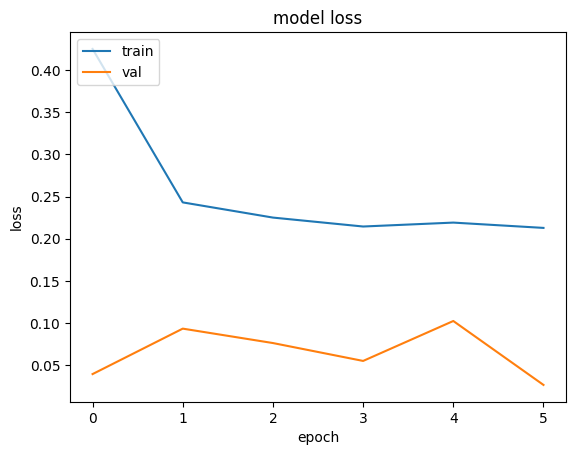

INFO:tensorflow:Assets written to: ram://b4118762-4a11-4a29-a232-90269bc5d2fb/assets


In [7]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

np.save("3Dunet_history_lesion.npy",np.array(history))



In [ ]:
#a zrób testowy trening od modelu do wątroby :))) mnoże będzie lepiej!

In [12]:
new_model = tf.keras.models.load_model("models\\2DUNET_lesion_16_256\0.0023-0.43-0.76-epoch-74.hdf5")


n_max = 700
n=0
for x in loader_valid.data_generator_2d_lesion():
   if n < 100:
      pass
   elif n < n_max:
      plt.subplot(1,3,1)
      plt.imshow(x[0])
      plt.subplot(1,3,2)
      preds = new_model.predict(tf.reshape(x[0],[1,256,256,1]))
      plt.imshow(preds[0,:,:,1])
      plt.subplot(1,3,3)
      plt.imshow(x[1][:,:,1])
      plt.show()
   else:
      break
   n+=1